In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, Grid, DenseNetwork, set_seed, Network
import os

from tensorflow.keras.optimizers import SGD, Adam

Main difference is testing star age learning

In [3]:
seed = 101
name = 'grid_29'
tracks = 'tracks_04c'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [4]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [5]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

In [6]:
len(train)

7736000

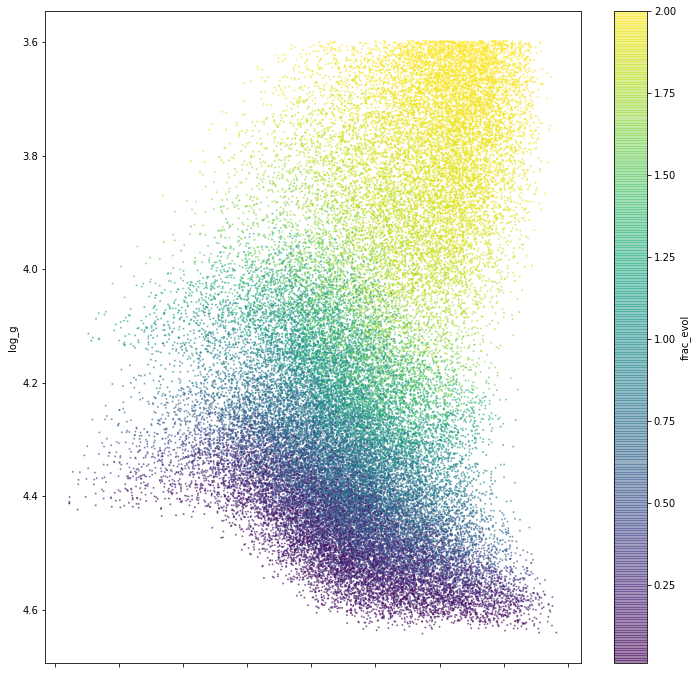

In [7]:
ax = train.sample(50000).plot(kind='scatter', x='effective_T', y='log_g',
                              c='frac_evol', cmap='viridis', s=1, figsize=(12, 12), alpha=0.5)
ax.invert_xaxis()
ax.invert_yaxis();

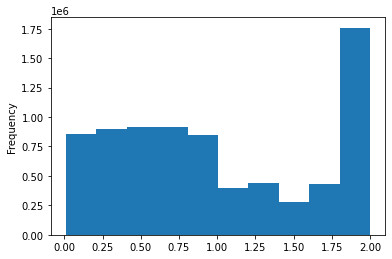

In [8]:
train.frac_evol.plot(kind='hist')

In [9]:
t = Tracks(name=tracks)
t.set_data(train)

del train

In [10]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,radius,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,frac_evol,gradient,log_star_age
0,2,0.90,0.28,0.30,2.1,1.208001,5096.0684,1.257615,1.440663,4.074041,0.250045,0.023094,0.244397,75.369644,0.025096,1.787780,0.001331,1.288534
1,1,1.05,0.30,0.35,2.3,0.802252,5795.2236,1.241361,1.106796,4.370944,0.265167,0.024596,0.281803,119.692590,0.027260,0.802252,0.000143,0.769161
2,1,1.00,0.26,0.45,1.5,0.257848,4885.7940,0.461555,0.949512,4.482889,0.244987,0.034190,0.418402,147.281680,0.035917,0.257848,0.000186,0.602735
3,1,0.83,0.24,0.10,1.7,0.133108,4709.6700,0.263781,0.772503,4.581167,0.230248,0.016330,0.078280,182.489150,0.016932,0.133108,0.000198,0.506814
4,1,1.20,0.32,-0.40,1.7,0.570906,7567.7803,5.058152,1.310140,4.282435,0.211951,0.003404,-0.620390,90.396866,0.004865,0.570906,0.000695,0.055732


In [11]:
len(t._data)

7736000

## Normalize

Let's choose the inputs and outputs and the normalise

In [12]:
x_cols = ['frac_evol', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'radius', 'delta_nu_fit', 'star_feh']

In [13]:
factors, _df = t.normalize(loc='50%', scale='std', columns=x_cols+y_cols)

In [14]:
factors

,column,norm_column,loc,scale
0,frac_evol,frac_evol_norm,0.864733,0.650730
1,initial_mass,initial_mass_norm,1.000000,0.117961
2,initial_MLT,initial_MLT_norm,1.900000,0.337950
3,initial_Yinit,initial_Yinit_norm,0.280000,0.028038
4,initial_Zinit,initial_Zinit_norm,0.016932,0.010687
5,log_star_age,log_star_age_norm,0.790410,0.466884
6,effective_T,effective_T_norm,5566.772000,601.172445
7,radius,radius_norm,1.223618,0.502612
8,delta_nu_fit,delta_nu_fit_norm,100.720155,42.581806
9,star_feh,star_feh_norm,0.081029,0.360937


Round the loc and scale to 3 dp

In [15]:
factors = round(factors, 3)

In [16]:
factors

,column,norm_column,loc,scale
0,frac_evol,frac_evol_norm,0.865,0.651
1,initial_mass,initial_mass_norm,1.000,0.118
2,initial_MLT,initial_MLT_norm,1.900,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.017,0.011
5,log_star_age,log_star_age_norm,0.790,0.467
6,effective_T,effective_T_norm,5566.772,601.172
7,radius,radius_norm,1.224,0.503
8,delta_nu_fit,delta_nu_fit_norm,100.720,42.582
9,star_feh,star_feh_norm,0.081,0.361


In [17]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,1.417480,-0.847458,0.591716,0.000000,0.735994,1.067524,-0.782977,0.430741,-0.595330,0.452623
1,-0.096387,0.423729,1.183432,0.714286,0.932727,-0.044623,0.380010,-0.233010,0.445554,0.556240
2,-0.932645,0.000000,-1.183432,-0.714286,1.719745,-0.400995,-1.132751,-0.545702,1.093459,0.934632
3,-1.124259,-1.440678,-0.591716,-1.428571,-0.006186,-0.606395,-1.425718,-0.897609,1.920275,-0.007535
4,-0.451758,1.694915,-0.591716,1.428571,-1.103196,-1.572307,3.328512,0.171253,-0.242430,-1.942907


In [18]:
del _df

In [19]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [20]:
t.norm_factors.to_csv(os.path.join(save_path, f'{name}_norm.csv'), index=False)

In [21]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols]+['gradient'])
train.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm,gradient
0,1.417480,-0.847458,0.591716,0.000000,0.735994,1.067524,-0.782977,0.430741,-0.595330,0.452623,0.001331
1,-0.096387,0.423729,1.183432,0.714286,0.932727,-0.044623,0.380010,-0.233010,0.445554,0.556240,0.000143
2,-0.932645,0.000000,-1.183432,-0.714286,1.719745,-0.400995,-1.132751,-0.545702,1.093459,0.934632,0.000186
3,-1.124259,-1.440678,-0.591716,-1.428571,-0.006186,-0.606395,-1.425718,-0.897609,1.920275,-0.007535,0.000198
4,-0.451758,1.694915,-0.591716,1.428571,-1.103196,-1.572307,3.328512,0.171253,-0.242430,-1.942907,0.000695


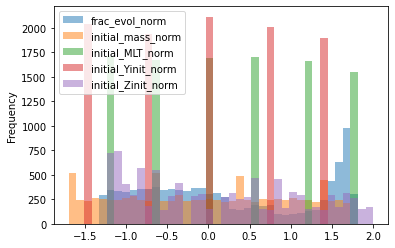

In [22]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols], bins=40, alpha=0.5)

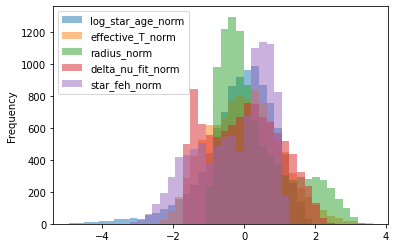

In [23]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Normalise training weights such that they are of order 1

In [24]:
train['weight'] = train['gradient']/train['gradient'].std()

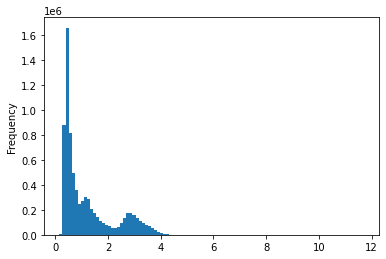

In [25]:
train['weight'].plot(kind='hist', bins=100)

Validation

In [26]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [27]:
t = Tracks()
t.set_data(val)

In [28]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [29]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,-1.309110,0.0,1.183432,-1.428571,-0.56619,-3.698857,0.325369,-0.700701,1.533307,-0.504890
1,-1.302925,0.0,1.183432,-1.428571,-0.56619,-3.443982,0.327236,-0.697468,1.522501,-0.506281
2,-1.278154,0.0,1.183432,-1.428571,-0.56619,-2.818129,0.333134,-0.688479,1.492790,-0.511842
3,-1.273483,0.0,1.183432,-1.428571,-0.56619,-2.735962,0.334265,-0.687043,1.488078,-0.512881
4,-1.225451,0.0,1.183432,-1.428571,-0.56619,-2.154124,0.346240,-0.673718,1.444744,-0.523512


In [30]:
del t

In [31]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [32]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 7736000
Length of validation data = 1933666


In [33]:
n_batches = np.arange(100, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 100  125  160  200  250  320  400  500  800  967 1000 1600 1934]


In [36]:
len(train)//500

15472

In [45]:
depth = [6]
width = [128]
activation = ['elu']
batch_size = [len(train)//500]
regularization_l2 = [1e-8, 1e-6, 1e-4]
optimizer = [SGD(0.0001, 0.999)]
loss = ['mae']
metrics = ['mae']

In [46]:
def get_config(self):
    config = dict(
        name=self.name,
        model_filename=self.model_filename,
        history_filename=self.history_filename,
        optimizer=str(self.optimizer),
        loss=self.loss,
        metrics=self.metrics,
        x_cols=self.x_cols,
        y_cols=self.y_cols
        )
    return config

In [47]:
DenseNetwork.get_config = get_config

In [48]:
def compile_all(self, loss='mae', metrics=None, **kwargs):
    '''Compile all neural networks on the grid. '''
    self.networks.apply(lambda network: network.compile(
        optimizer=grid.data.loc[grid.data.index==network.name, 'optimizer'].values[0], 
        loss=grid.data.loc[grid.data.index==network.name, 'loss'].values[0], 
        metrics=metrics, **kwargs))

Grid.compile_all = compile_all

In [49]:
class CustomNetwork(DenseNetwork):

    def __init__(self, path=None, name=None, class_weight=None, **kwargs):

        super().__init__(path=path, name=name, **kwargs)
        self.class_weight = class_weight
   
    def custom_train(self, *args, **kwargs):
        '''Trains using batch size parameter'''
        if fit_kw in kwargs:
            fit_kw['class_weight'] = self.class_weight
        else:
            fit_kw = {'class_weight': self.class_weight}
    
        super().train(*args, fit_kw=fit_kw, **kwargs)

In [50]:
grid = Grid(path=save_path, name=name, depth=depth, width=width,
                        activation=activation, batch_size=batch_size,
                        regularization_l2=regularization_l2, optimizer=optimizer, loss=loss)

grid.data

,depth,width,activation,batch_size,regularization_l2,optimizer,loss
name,,,,,,,
grid_29_0,6,128,elu,15472,1.000000e-08,<tensorflow.python.keras.optimizer_v2.gradient...,mae
grid_29_1,6,128,elu,15472,1.000000e-06,<tensorflow.python.keras.optimizer_v2.gradient...,mae
grid_29_2,6,128,elu,15472,1.000000e-04,<tensorflow.python.keras.optimizer_v2.gradient...,mae


In [51]:
grid.make_networks(CustomNetwork, 
                   param_columns=['depth', 'width', 'activation', 'batch_size', 'regularization_l2'])

In [52]:
grid.build_all(len(x_cols), len(y_cols))

In [53]:
grid.compile_all(metrics=metrics)

In [54]:
fit_kw = dict(sample_weight=train['weight'].to_numpy())

grid.train_all(train, x_cols, y_cols, epochs=50, validation_data=val, validation_split=None,
               callbacks=['tensorboard'], fit_kw=fit_kw)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


Add a function which plots history for all networks.

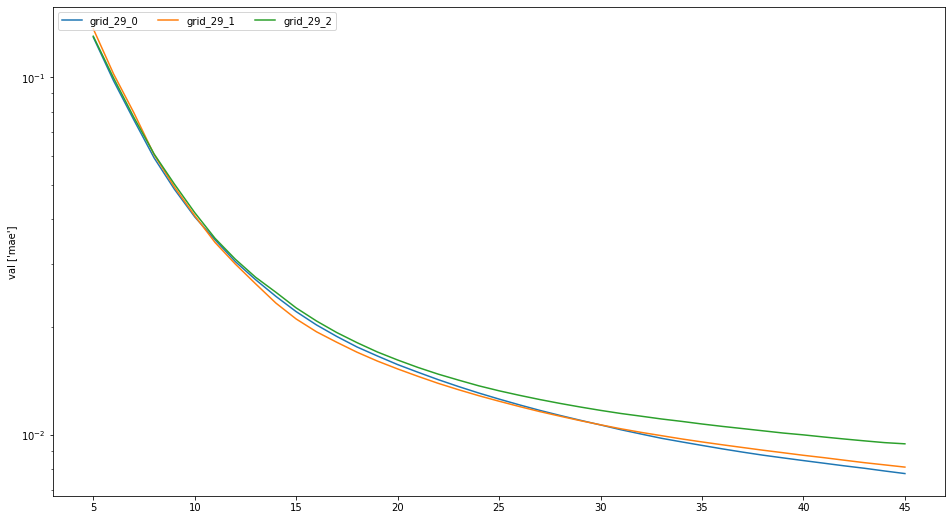

In [55]:
fig, ax = plt.subplots(figsize=(16, 9))
filter_width = 10  # filter width in epochs

for network in grid.networks:
#     network.history.plot(ax=ax, x='epochs', y=['val_loss'], logy=True, alpha=0.5,
#                          label=[f'{network.name} val loss'])
    df = network.history
    y = np.convolve(network.history.val_mae, np.ones((filter_width,))/filter_width, mode='valid')
    ax.plot(df.iloc[filter_width//2:-filter_width//2+1].epochs, y, label=f'{network.name}')
ax.set_ylabel(f'val {loss}')
ax.set_yscale('log')

ax.legend(loc='upper left', ncol=8)

In [56]:
grid.evaluate_all(val.sample(n=5000))

,loss,mae
name,,
grid_29_0,0.007217,0.007210
grid_29_1,0.008213,0.007542
grid_29_2,0.039411,0.009242


In [57]:
import seaborn as sns

In [58]:
val = val.sample(n=20000)

In [59]:
df_dict = {}
for i, network in enumerate(grid.networks):
#     network = grid.networks[i]
    df_dict[network.name] = np.abs(network.predict(val, batch_size=network.batch_size) - \
                                   val[y_cols].reset_index(drop=True))

In [60]:
df_err = pd.concat(df_dict).reset_index(level=0).rename(columns={'level_0': 'name'})
df_err.head()

,name,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_29_0,0.003509,0.000173,0.003964,0.002071,0.000166
1,grid_29_0,0.001857,0.011648,0.004385,0.013998,0.010570
2,grid_29_0,0.001034,0.002033,0.003632,0.001793,0.000450
3,grid_29_0,0.002891,0.004307,0.006670,0.001964,0.005129
4,grid_29_0,0.003819,0.002485,0.002130,0.003088,0.005718


In [61]:
df_mae = pd.concat(df_dict).mean(axis=1).reset_index(level=0).rename(columns={'level_0': 'name', 0: 'mae'})
df_mae.head()

,name,mae
0,grid_29_0,0.001977
1,grid_29_0,0.008492
2,grid_29_0,0.001788
3,grid_29_0,0.004192
4,grid_29_0,0.003448


In [62]:
df_mae['log_mae'] = np.log10(df_mae['mae'])

In [63]:
order = df_mae.set_index('name').median(level=0).sort_values('log_mae', ascending=False).index

In [64]:
df_err.head()

,name,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_29_0,0.003509,0.000173,0.003964,0.002071,0.000166
1,grid_29_0,0.001857,0.011648,0.004385,0.013998,0.010570
2,grid_29_0,0.001034,0.002033,0.003632,0.001793,0.000450
3,grid_29_0,0.002891,0.004307,0.006670,0.001964,0.005129
4,grid_29_0,0.003819,0.002485,0.002130,0.003088,0.005718


In [65]:
df_err_col = df_err.set_index('name').stack().reset_index().rename(columns={'level_1': 'output',
                                                                0: 'abs_err'})

df_err_col['log_abs_err'] = np.log10(df_err_col['abs_err'])

In [66]:
scores = grid.score_all(val, metric='absolute_error')

In [67]:
scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
grid_29_0,0.010458,0.018593,0.011029,0.009062,0.017639
grid_29_1,0.010287,0.018498,0.010989,0.009039,0.016693
grid_29_2,0.021059,0.020939,0.011762,0.009860,0.023856


In [68]:
factors.loc[5:, 'scale'].to_numpy() * scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
grid_29_0,0.004884,11.177404,0.005548,0.385869,0.006368
grid_29_1,0.004804,11.120618,0.005527,0.384896,0.006026
grid_29_2,0.009835,12.587998,0.005916,0.419863,0.008612


<IPython.core.display.Javascript object>


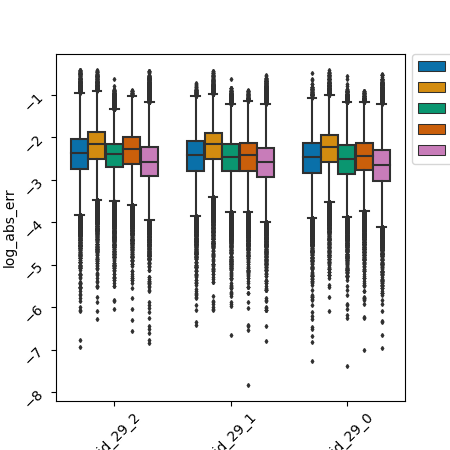

In [69]:
%matplotlib notebook

w = 1.5 * len(grid.data)
fig, ax = plt.subplots(figsize=(w, 4.5))
width = 0.15 * len(y_cols)
sns.boxplot(data=df_err_col, x='name', y='log_abs_err', hue='output',
            width=width, fliersize=2, color='C0', palette='colorblind',
            order=order, ax=ax, saturation=0.9)
# ax.set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.02))

The tails are fairly extreme for MAE

In [72]:
network = grid.networks[1]

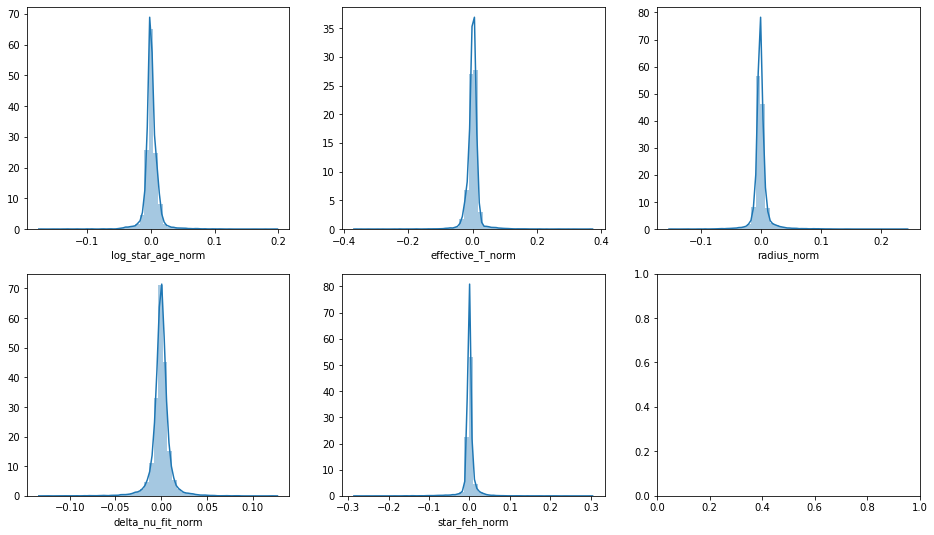

In [73]:
%matplotlib inline

network.plot_metric(val, metric='error', save_plot=False);

We see that for MSE the tails are less extreme

In [81]:
network = grid.networks[3]

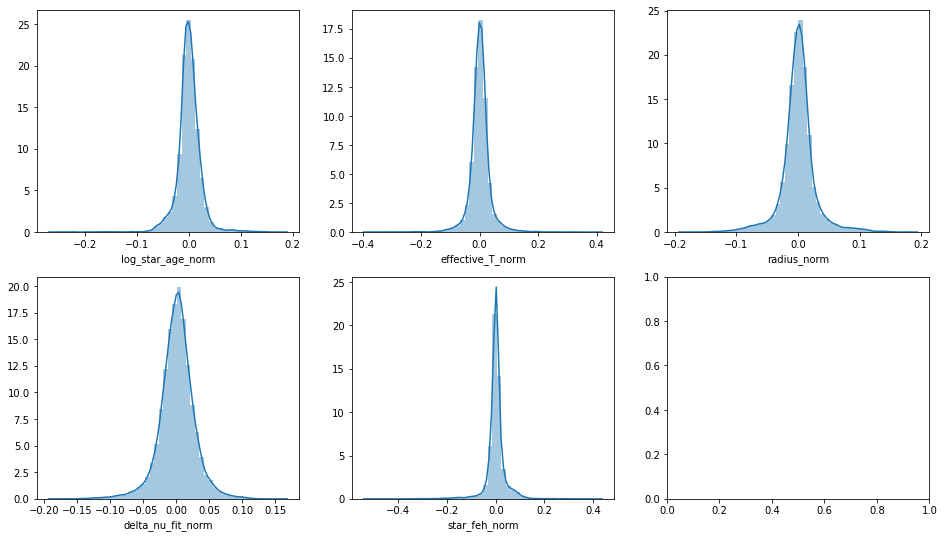

In [82]:
%matplotlib inline

network.plot_metric(val, metric='error', save_plot=False);